In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Hyperparameters
latent_dim = 100
batch_size = 128
epochs = 200

# Create the generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Create the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = MNIST(root='mnist_data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)  # Get the current batch size
        # Train discriminator with real images
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1)
        real_outputs = discriminator(real_images)
        D_real_loss = criterion(real_outputs, real_labels)
        D_real_loss.backward()

        # Train discriminator with fake images
        z = torch.randn(batch_size, latent_dim)
        fake_images = generator(z)
        fake_labels = torch.zeros(batch_size, 1)
        fake_outputs = discriminator(fake_images.detach())
        D_fake_loss = criterion(fake_outputs, fake_labels)
        D_fake_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)
        G_loss = criterion(fake_outputs, real_labels)
        G_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Batch [{i}/{len(train_loader)}], "
                  f"D_loss: {D_real_loss + D_fake_loss:.4f}, G_loss: {G_loss:.4f}")

# Generate and save sample images
if not os.path.exists('images'):
    os.makedirs('images')

z = torch.randn(16, latent_dim)
generated_images = generator(z)
for i in range(generated_images.size(0)):
    image = generated_images[i].view(28, 28).detach().numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(f'images/sample_{i + 1}.png')
    plt.close()

print("Training completed.")

100.0%


Extracting mnist_data\MNIST\raw\train-images-idx3-ubyte.gz to mnist_data\MNIST\raw



100.0%


Extracting mnist_data\MNIST\raw\train-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



100.0%


Extracting mnist_data\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist_data\MNIST\raw



100.0%


Extracting mnist_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist_data\MNIST\raw

Epoch [1/200], Batch [0/469], D_loss: 1.3771, G_loss: 0.6830
Epoch [1/200], Batch [100/469], D_loss: 0.0384, G_loss: 5.5238
Epoch [1/200], Batch [200/469], D_loss: 0.0149, G_loss: 8.1493
Epoch [1/200], Batch [300/469], D_loss: 0.0534, G_loss: 10.3977
Epoch [1/200], Batch [400/469], D_loss: 0.4372, G_loss: 31.9000
Epoch [2/200], Batch [0/469], D_loss: 0.0335, G_loss: 26.9487
Epoch [2/200], Batch [100/469], D_loss: 0.0780, G_loss: 16.0971
Epoch [2/200], Batch [200/469], D_loss: 0.2026, G_loss: 8.0482
Epoch [2/200], Batch [300/469], D_loss: 0.2800, G_loss: 6.0695
Epoch [2/200], Batch [400/469], D_loss: 0.1539, G_loss: 7.1080
Epoch [3/200], Batch [0/469], D_loss: 0.1041, G_loss: 11.6433
Epoch [3/200], Batch [100/469], D_loss: 0.2008, G_loss: 10.3211
Epoch [3/200], Batch [200/469], D_loss: 0.0979, G_loss: 8.5209
Epoch [3/200], Batch [300/469], D_loss: 0.1520, G_loss: 6.6967
Epoch [3/200], Batch [400/469], D_l

In [6]:
torch.save(generator.state_dict(), os.path.join('models', 'DCGAN_MNIST_generator.pth'))
torch.save(discriminator.state_dict(), os.path.join('models', 'DCGAN_MNIST_discriminator.pth'))
print("Trained models saved.")

Trained models saved.


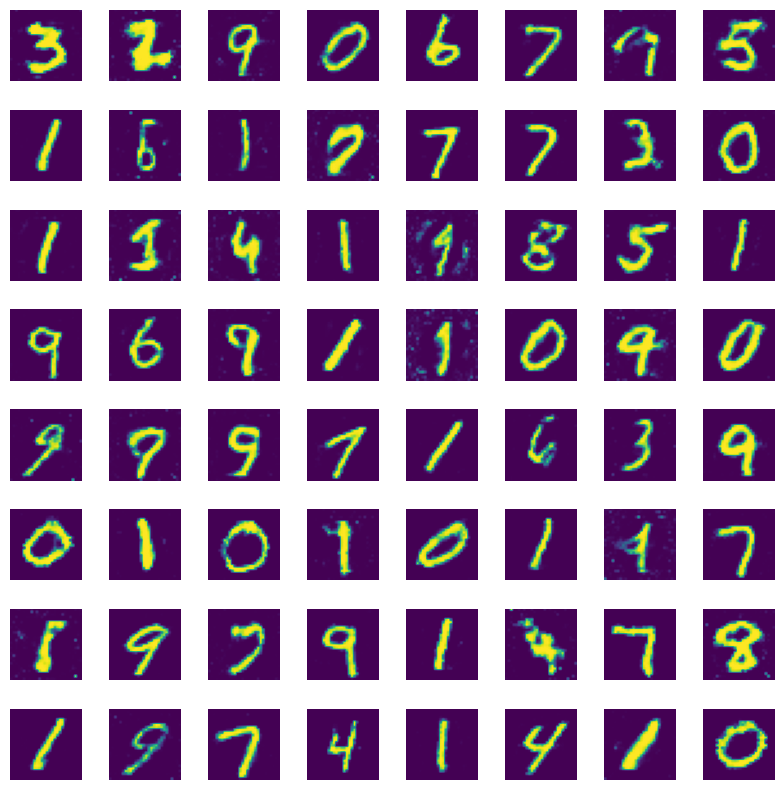

In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

# Hyperparameters
latent_dim = 100

# Initialize the generator
generator = Generator()
generator.load_state_dict(torch.load('models/DCGAN_MNIST_generator.pth'))

# Generate new images
num_samples = 64
z = torch.randn(num_samples, latent_dim)
with torch.no_grad():
    generated_images = generator(z)

# Display the generated images
fig, axs = plt.subplots(8, 8, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4)
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(generated_images[i * 8 + j].view(28, 28))
        axs[i, j].axis('off')

plt.show()


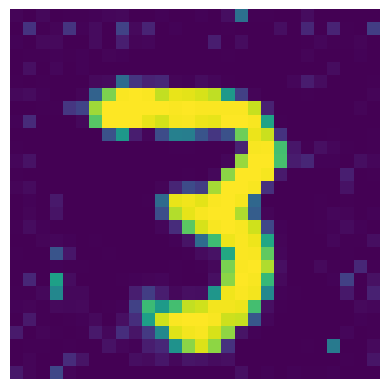

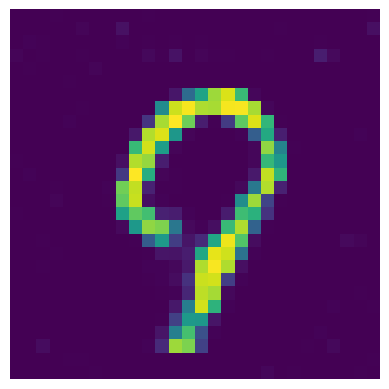

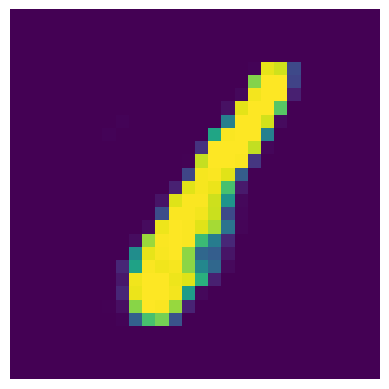

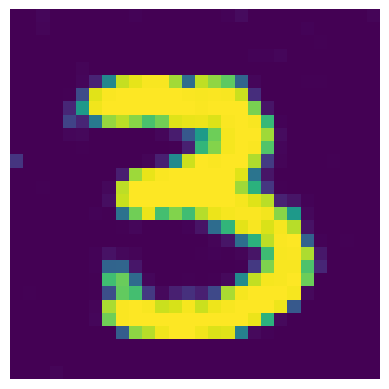

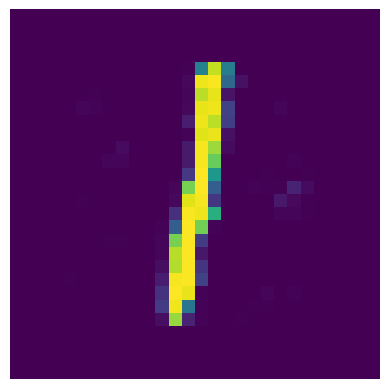

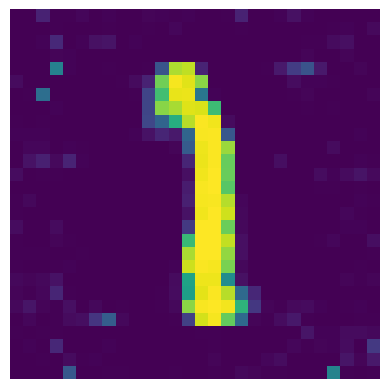

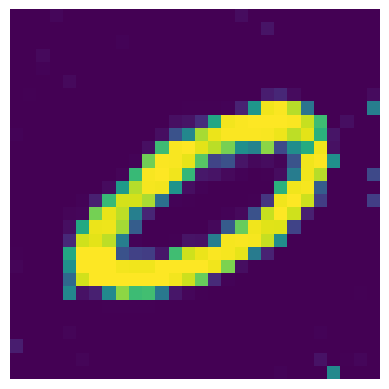

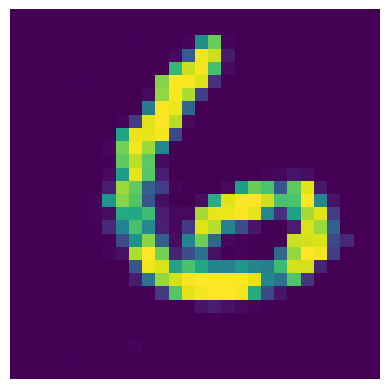

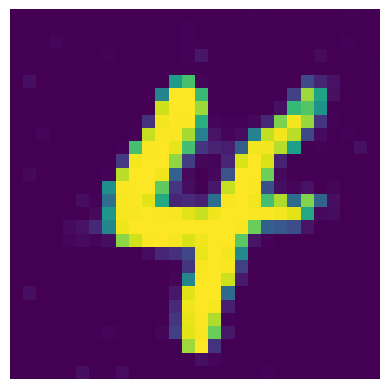

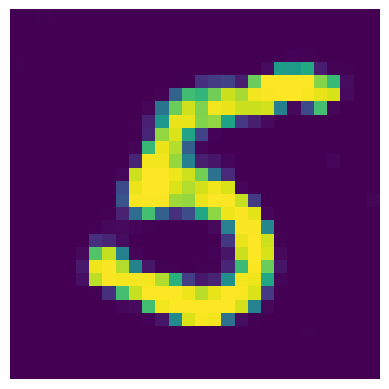

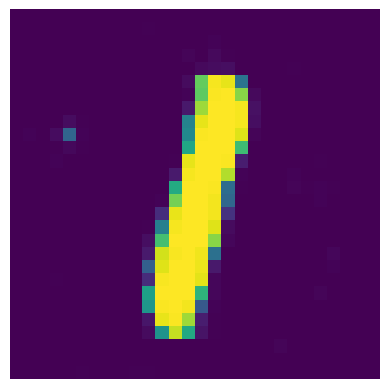

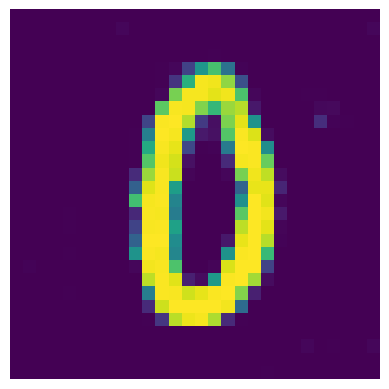

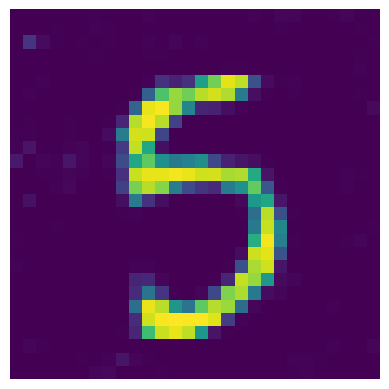

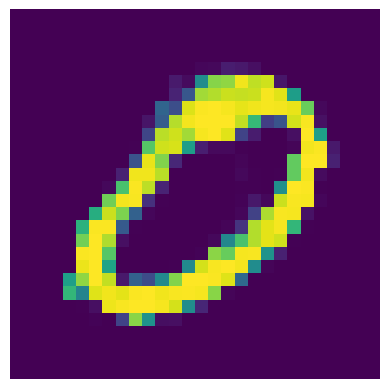

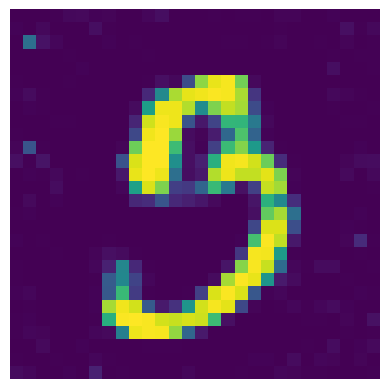

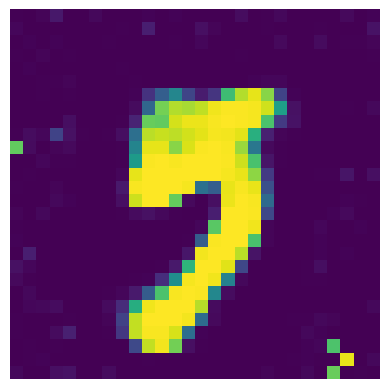

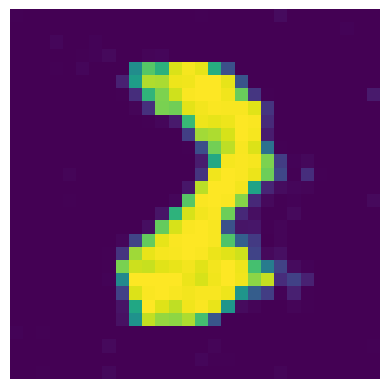

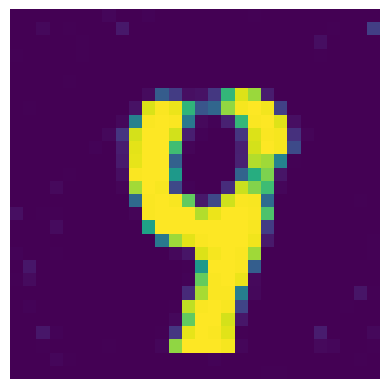

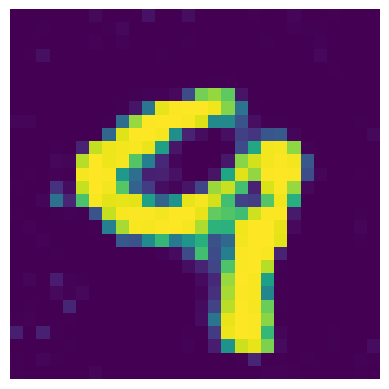

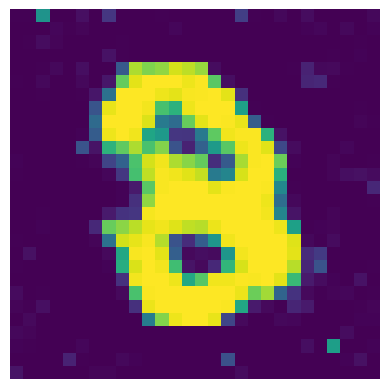

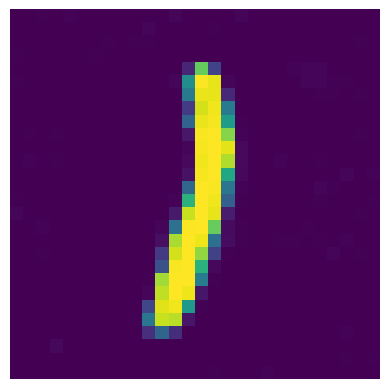

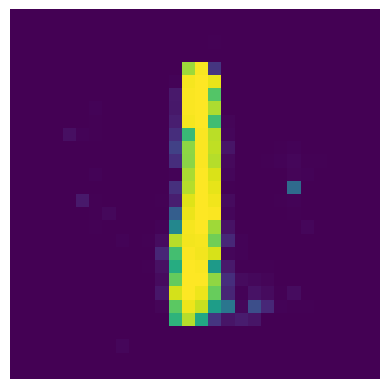

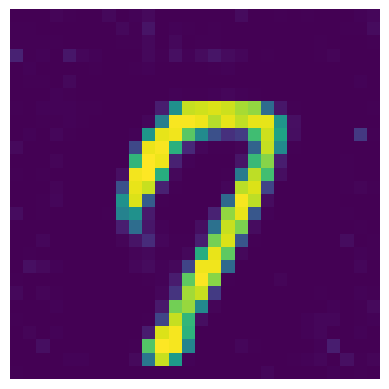

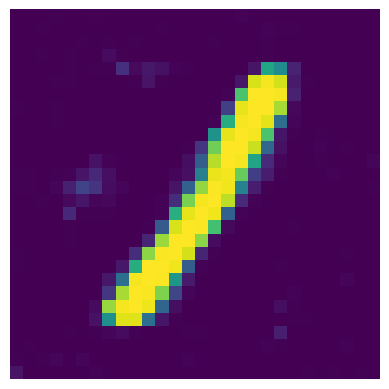

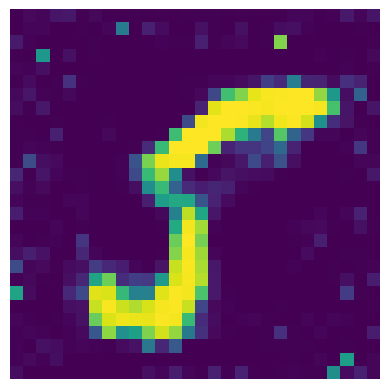

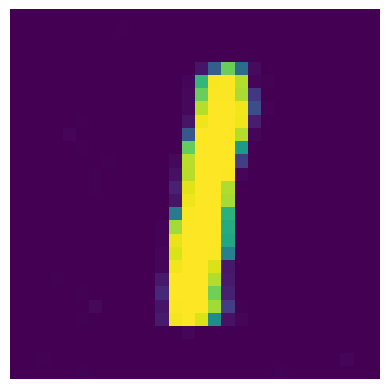

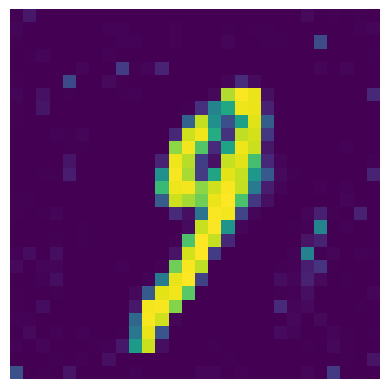

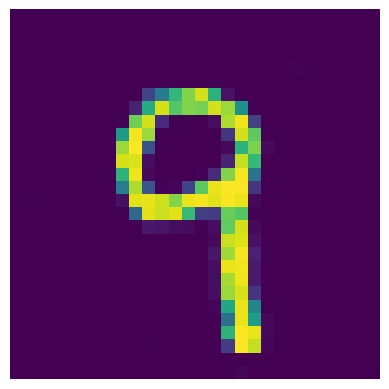

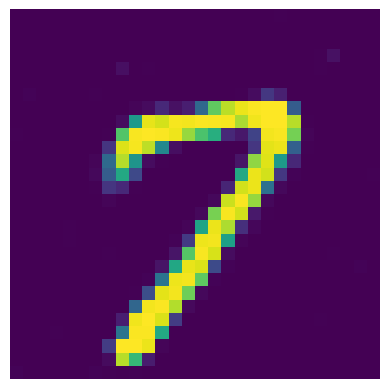

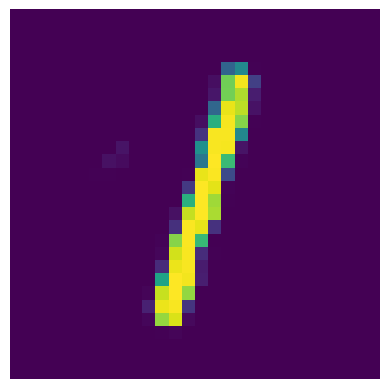

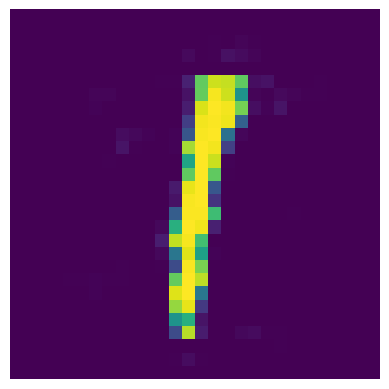

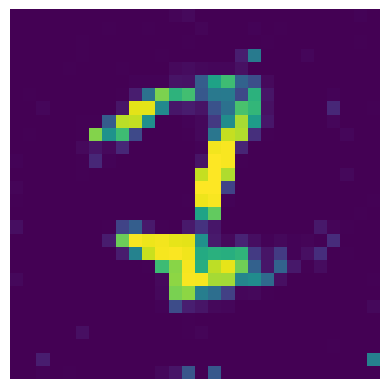

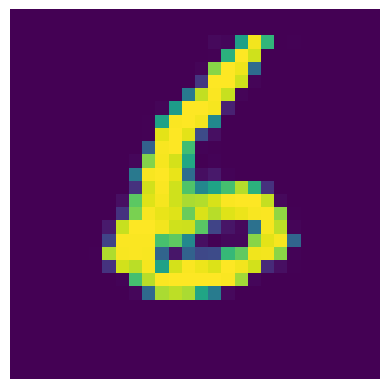

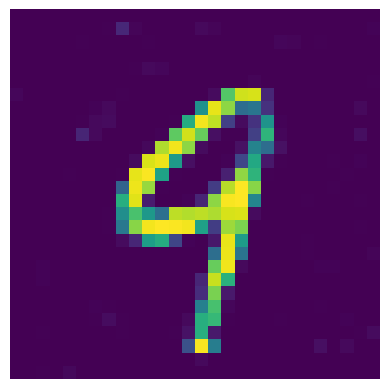

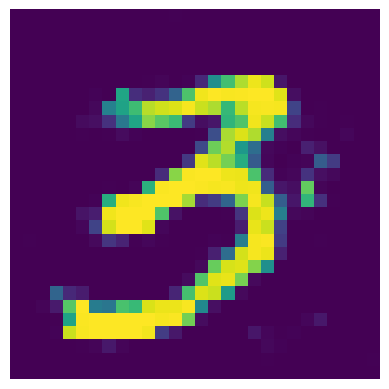

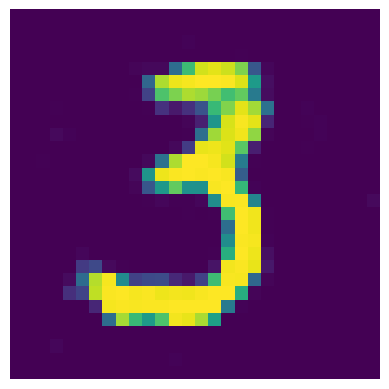

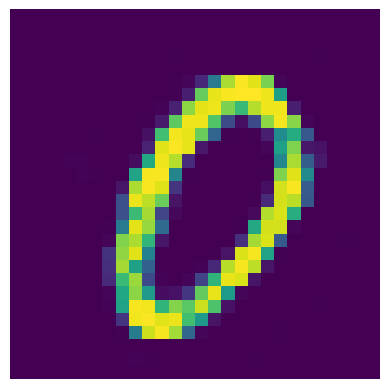

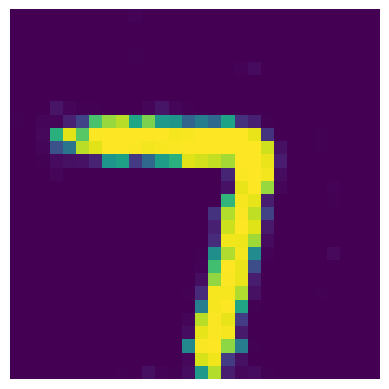

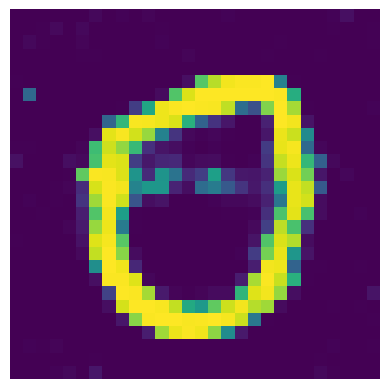

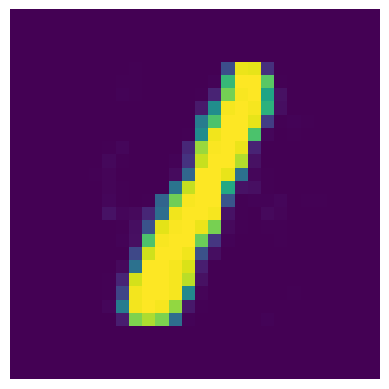

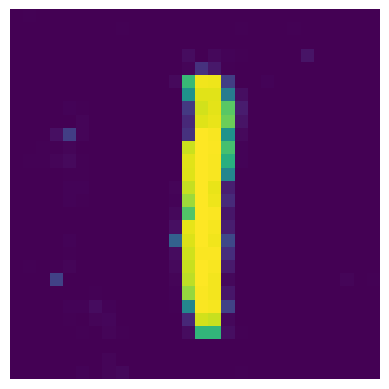

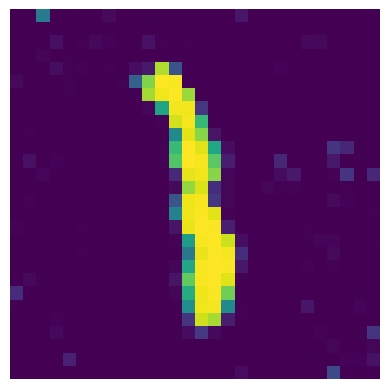

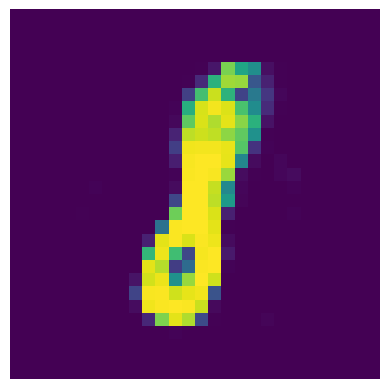

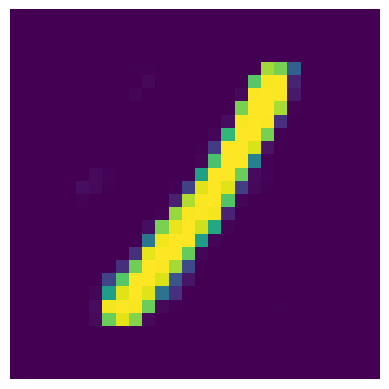

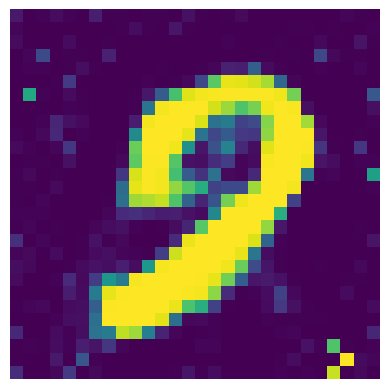

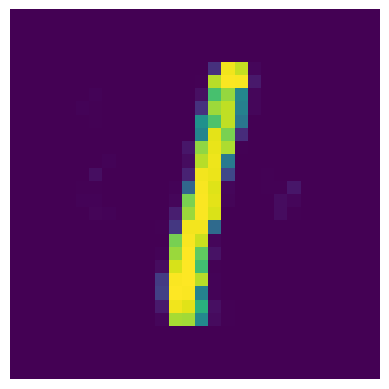

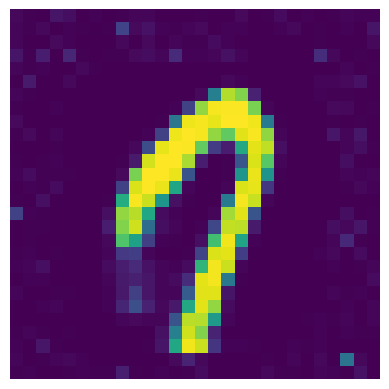

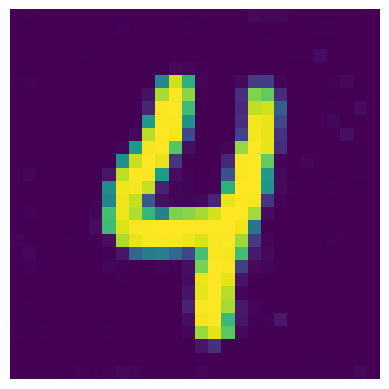

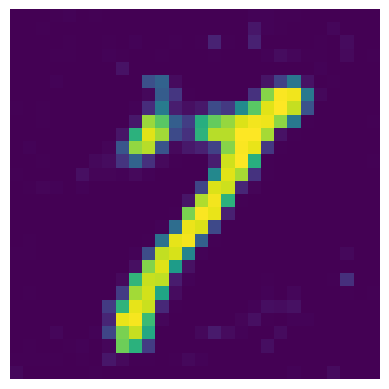

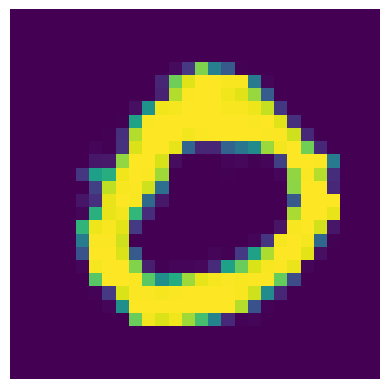

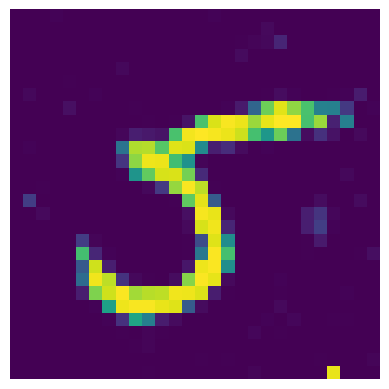

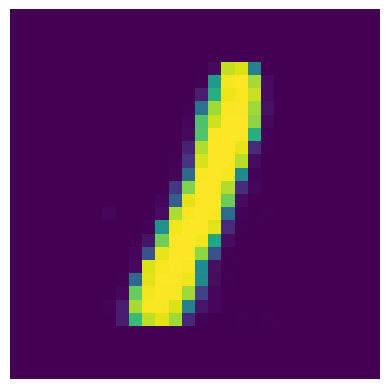

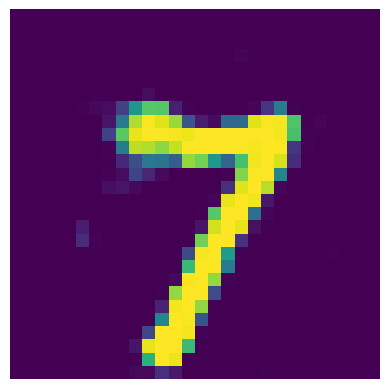

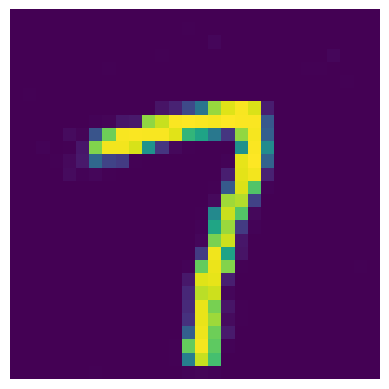

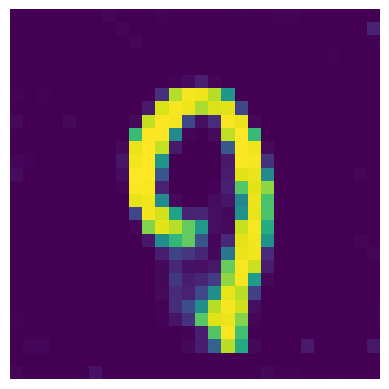

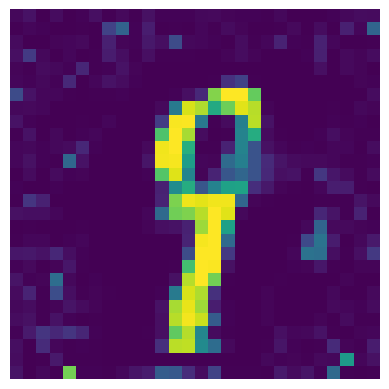

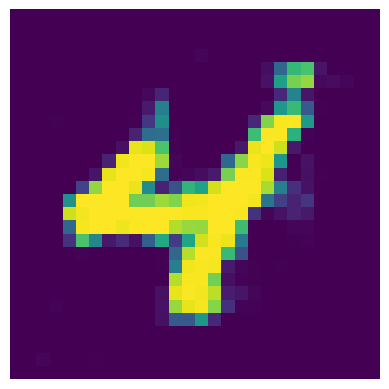

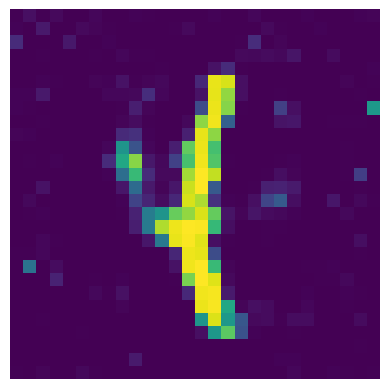

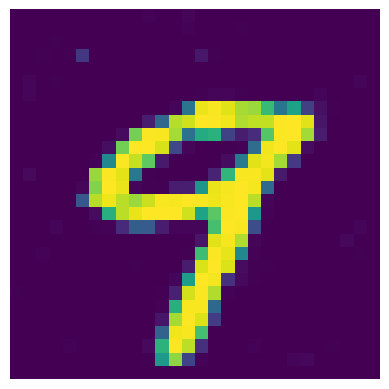

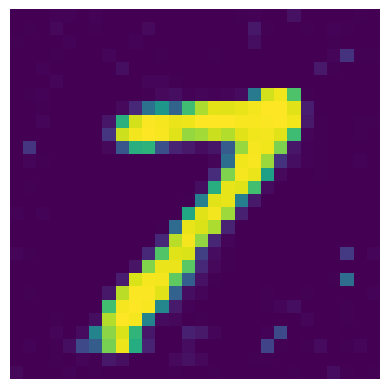

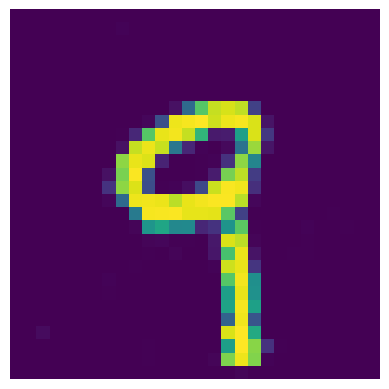

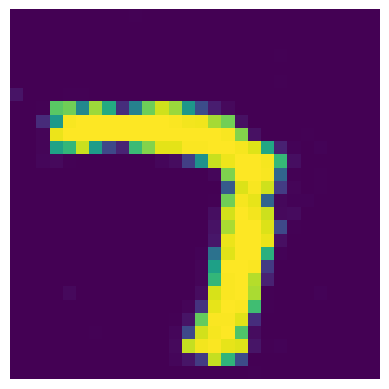

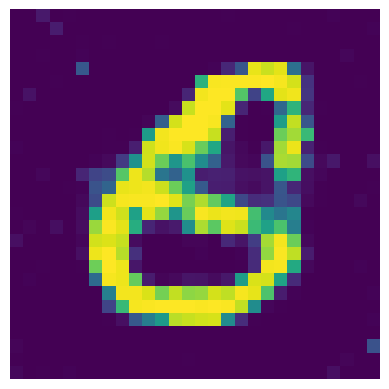

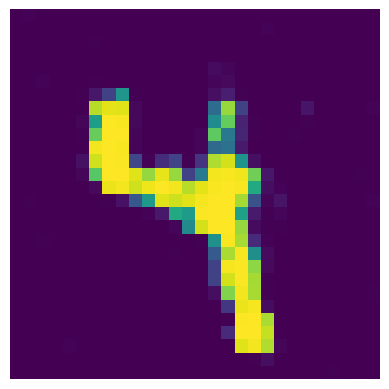

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

# Hyperparameters
latent_dim = 100

# Initialize the generator
generator = Generator()
generator.load_state_dict(torch.load('models/DCGAN_MNIST_generator.pth'))
if not os.path.exists('generated_images'):
    os.makedirs('generated_images')

# Generate and save new images
num_samples = 10
z = torch.randn(num_samples, latent_dim)
generated_images = generator(z)

for i in range(generated_images.size(0)):
    image = generated_images[i].view(28, 28).detach().numpy()

    # Display the generated image using matplotlib
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Save the generated image
    image_path = f'generated_images/generated_image_{i + 1}.png'
    plt.imsave(image_path, image)
